In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import pathlib
import PIL
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
train_path = pathlib.Path("../input/chest-xray-pneumonia/chest_xray/train")
val_path = pathlib.Path("../input/chest-xray-pneumonia/chest_xray/val")
test_path = pathlib.Path("../input/chest-xray-pneumonia/chest_xray/test")

In [4]:
image_count = len(list(train_path.glob("*/*.jpeg")))
image_count

5216

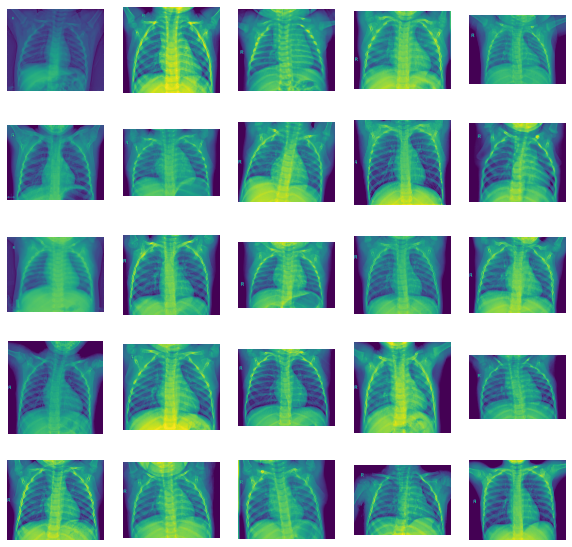

In [5]:
normal_vis = list(train_path.glob("NORMAL/*.jpeg"))
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = PIL.Image.open(str(normal_vis[i]))
    plt.imshow(img)
    plt.axis(False)
    
#del normal_vis

In [6]:
batch_size = 100
image_width = 128
image_height = 128
random_state = 100

In [7]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = (image_height, image_width),
    batch_size = batch_size
)

Found 5216 files belonging to 2 classes.


2022-06-24 16:19:46.110440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 16:19:46.266432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 16:19:46.267442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 16:19:46.270680: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [8]:
class_names = train_data.class_names
class_names

['NORMAL', 'PNEUMONIA']

2022-06-24 16:21:15.577849: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


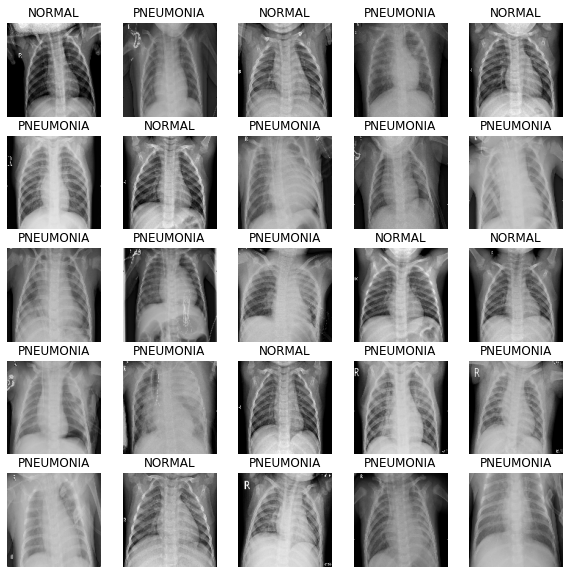

In [9]:
plt.figure(figsize = (10, 10))
for images, labels in train_data.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis(False)

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)]
)

In [11]:
data_preprocessing_resnet = tf.keras.applications.resnet.preprocess_input

base_model_resnet = tf.keras.applications.resnet.ResNet50(
    input_shape = (image_height, image_width, 3),
    include_top = False,
    weights = "imagenet"
)


94781440/94765736 [==============================] - 1s 0us/step


In [12]:
base_model_resnet.trainable = False

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(1, activation = "sigmoid")


In [14]:
inputs = tf.keras.Input((128, 128, 3))
x = data_augmentation(inputs)
x = data_preprocessing_resnet(x)
x = base_model_resnet(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model_resnet = tf.keras.Model(inputs = inputs, outputs = outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)

model_resnet.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5)
history_resnet = model_resnet.fit(train_data, validation_data = val_data, batch_size = 100, epochs = 1000, callbacks=[early_stopping])

Epoch 1/1000


2022-06-24 16:43:46.820312: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


53/53 [==============================] - 56s 776ms/step - loss: 2.4723 - accuracy: 0.8629 - val_loss: 3.1525 - val_accuracy: 0.8125
Epoch 2/1000
53/53 [==============================] - 29s 454ms/step - loss: 0.6927 - accuracy: 0.9247 - val_loss: 2.5551 - val_accuracy: 0.6875
Epoch 3/1000
53/53 [==============================] - 31s 455ms/step - loss: 0.3912 - accuracy: 0.9369 - val_loss: 5.1083 - val_accuracy: 0.6250
Epoch 4/1000
53/53 [==============================] - 28s 459ms/step - loss: 0.5211 - accuracy: 0.9233 - val_loss: 2.4661 - val_accuracy: 0.6875
Epoch 5/1000
53/53 [==============================] - 29s 454ms/step - loss: 0.5576 - accuracy: 0.9247 - val_loss: 0.7814 - val_accuracy: 0.8750
Epoch 6/1000
53/53 [==============================] - 29s 464ms/step - loss: 0.6265 - accuracy: 0.9231 - val_loss: 1.9515 - val_accuracy: 0.6875
Epoch 7/1000
52/53 [============================>.] - ETA: 0s - loss: 0.6241 - accuracy: 0.9292

In [ ]:
#PLotting the graph between epochs loss for loss and val_loss

sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["loss"], label = "Training")
sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["val_loss"], label = "Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
#PLotting the graph between epochs loss for accuracy and val_accuracy

sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["accuracy"], label = "Training")
sb.lineplot(x = range(len(history_resnet.history["loss"])), y = history_resnet.history["val_accuracy"], label = "Validation")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc = "lower right")

In [ ]:
# Evaluate the model
result_resnet = model_resnet.evaluate(test_data)
print(f"Loss: {result_resnet[0]}")
print(f"Accuracy: {result_resnet[1] * 100}")

In [ ]:
# H.W.
# Save the model
# Load the model
# And also visualize your model on netron.app
# Model Prediction on test images ==> Make a Dataframe (columns ==> 1. Image_name 2. Class_name)